# MPO Pitch Control for LIGO Suspensions

This notebook trains a Maximum a Posteriori Policy Optimization (MPO) agent to control pitch dynamics of LIGO test masses using transfer function data. It includes:
- Transfer function loading and state-space conversion
- Seismic and sensor noise injection
- Training with deep loop shaping reward
- Evaluation with noise analysis
- Strain sensitivity calculation

In [1]:
# =============================================================================
# Imports and Setup
# =============================================================================
import numpy as np
import matplotlib.pyplot as plt
from collections import deque
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.distributions import Normal
import gymnasium as gym
from gymnasium import spaces
from scipy import signal
from scipy.signal import zpk2ss, cont2discrete, tf2ss, welch, butter, lfilter, lfilter_zi, find_peaks, sosfilt
from scipy.linalg import solve_discrete_are
import warnings
warnings.filterwarnings('ignore')

# Set random seeds for reproducibility
np.random.seed(42)
torch.manual_seed(42)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Sampling frequency
fs = 256  # Hz
dt = 1.0 / fs
print(f"Sampling frequency: {fs} Hz, dt = {dt:.6f} s")

Using device: cpu
Sampling frequency: 256 Hz, dt = 0.003906 s


In [18]:
# =============================================================================
# Load Transfer Functions and REAL Noise Data from LIGO
# =============================================================================
import h5py
from scipy.signal import resample

tf_path = '/Users/arushpimpalkar/work/timepass/RL_Arush/zenodo_data/transfer_functions/'
noise_path = '/Users/arushpimpalkar/work/timepass/RL_Arush/zenodo_data/noise_inputs/'
hdf5_path = '/Users/arushpimpalkar/work/timepass/RL_Arush/zenodo_data/hdf5/'

def load_tf_csv(filepath):
    """Load transfer function from CSV file (frequency, complex value)"""
    data = []
    with open(filepath, 'r') as f:
        for line in f:
            parts = line.strip().split()
            freq = float(parts[0])
            complex_val = complex(parts[1].replace('j', 'j'))
            data.append((freq, complex_val))
    freqs = np.array([d[0] for d in data])
    H = np.array([d[1] for d in data])
    return freqs, H

def load_noise_file(filepath):
    """Load noise ASD file, auto-detecting comma or space delimiter"""
    with open(filepath, 'r') as f:
        first_line = f.readline()
    if ',' in first_line:
        data = np.loadtxt(filepath, delimiter=',')
    else:
        data = np.loadtxt(filepath)
    return data[:, 0], data[:, 1]

# Load all three transfer functions
freq_L, H_topL = load_tf_csv(tf_path + 'tf_topL_2_tstP.csv')
freq_NL, H_topNL = load_tf_csv(tf_path + 'tf_topNL_2_tstP.csv')
freq_NP, H_topNP = load_tf_csv(tf_path + 'tf_topNP_2_tstP.csv')

# Load ASD specifications (for reference/comparison plots)
freq_sei_asd, sei_asd_ref = load_noise_file(noise_path + 'ETM_SEI_LIGO_O3.csv')
freq_sensor, sensor_noise_asd_raw = load_noise_file(noise_path + 'SENSOR_PITCH_HARD.csv')

# =============================================================================
# Load REAL Time-Domain Noise from LIGO HDF5 Files
# =============================================================================
print("Loading REAL LIGO noise data from HDF5...")

with h5py.File(hdf5_path + 'L1_1407160711.hdf5', 'r') as f:
    # Load the pitch error signal - this contains real sensor noise + seismic effects
    real_noise_raw = f['L1:SBR-CHARD_P_ERR_OUT_DQ'][:]
    real_noise_fs_original = 1.0 / f['L1:SBR-CHARD_P_ERR_OUT_DQ'].attrs['dx']
    
print(f"\\nReal LIGO noise loaded:")
print(f"  Original sample rate: {real_noise_fs_original:.0f} Hz")
print(f"  Total samples: {len(real_noise_raw):,}")
print(f"  Duration: {len(real_noise_raw)/real_noise_fs_original:.1f} seconds ({len(real_noise_raw)/real_noise_fs_original/60:.1f} minutes)")

# Resample to our target sample rate (256 Hz)
resample_factor = int(real_noise_fs_original / fs)
real_noise_resampled = real_noise_raw[::resample_factor]  # Simple decimation (assuming anti-aliasing)

print(f"\\nResampled to {fs} Hz:")
print(f"  Samples: {len(real_noise_resampled):,}")
print(f"  Duration: {len(real_noise_resampled)/fs:.1f} seconds")
print(f"  RMS: {np.std(real_noise_resampled):.3e}")

# Normalize/scale the real noise (it's in arbitrary units, scale to match our simulation)
# The real noise will be used as the disturbance input
real_noise_scale = 1e-9  # Scale factor to convert to appropriate physical units
real_noise = real_noise_resampled * real_noise_scale

print(f"  Scaled RMS: {np.std(real_noise):.3e}")

print("\\nTransfer Functions Loaded:")
print(f"  tf_topL_2_tstP: {len(freq_L)} points, {freq_L[0]:.4f}-{freq_L[-1]:.2f} Hz")
print(f"  tf_topNL_2_tstP: {len(freq_NL)} points")
print(f"  tf_topNP_2_tstP: {len(freq_NP)} points")

Loading REAL LIGO noise data from HDF5...
\nReal LIGO noise loaded:
  Original sample rate: 2048 Hz
  Total samples: 9,926,656
  Duration: 4847.0 seconds (80.8 minutes)
\nResampled to 256 Hz:
  Samples: 1,240,832
  Duration: 4847.0 seconds
  RMS: 2.745e+01
  Scaled RMS: 2.745e-08
\nTransfer Functions Loaded:
  tf_topL_2_tstP: 1000 points, 0.0100-256.00 Hz
  tf_topNL_2_tstP: 1000 points
  tf_topNP_2_tstP: 1000 points


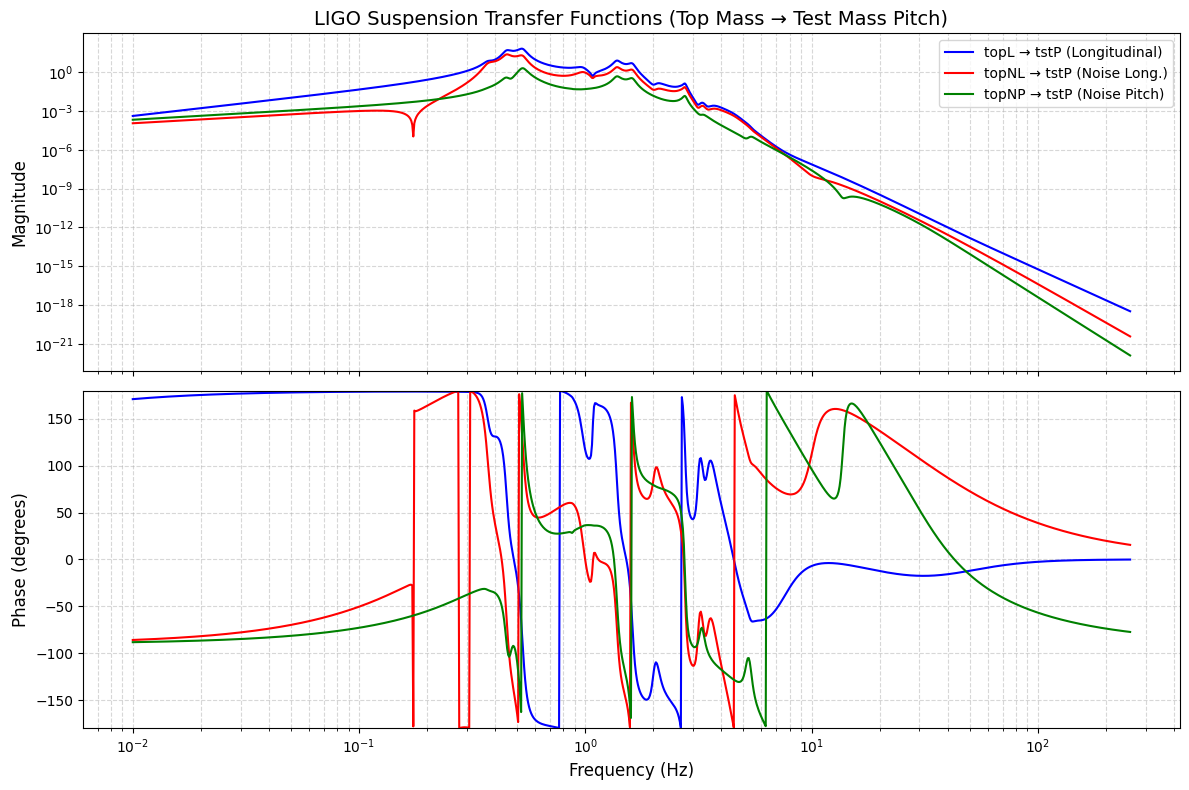

In [3]:
# =============================================================================
# Plot Transfer Functions (Bode Plots)
# =============================================================================
fig, axes = plt.subplots(2, 1, figsize=(12, 8), sharex=True)

# Magnitude plot
ax1 = axes[0]
ax1.loglog(freq_L, np.abs(H_topL), 'b-', linewidth=1.5, label='topL → tstP (Longitudinal)')
ax1.loglog(freq_NL, np.abs(H_topNL), 'r-', linewidth=1.5, label='topNL → tstP (Noise Long.)')
ax1.loglog(freq_NP, np.abs(H_topNP), 'g-', linewidth=1.5, label='topNP → tstP (Noise Pitch)')
ax1.set_ylabel('Magnitude', fontsize=12)
ax1.set_title('LIGO Suspension Transfer Functions (Top Mass → Test Mass Pitch)', fontsize=14)
ax1.legend(loc='best', fontsize=10)
ax1.grid(True, which='both', linestyle='--', alpha=0.5)

# Phase plot
ax2 = axes[1]
ax2.semilogx(freq_L, np.angle(H_topL, deg=True), 'b-', linewidth=1.5)
ax2.semilogx(freq_NL, np.angle(H_topNL, deg=True), 'r-', linewidth=1.5)
ax2.semilogx(freq_NP, np.angle(H_topNP, deg=True), 'g-', linewidth=1.5)
ax2.set_xlabel('Frequency (Hz)', fontsize=12)
ax2.set_ylabel('Phase (degrees)', fontsize=12)
ax2.grid(True, which='both', linestyle='--', alpha=0.5)
ax2.set_ylim([-180, 180])

plt.tight_layout()
plt.show()

In [4]:
# =============================================================================
# Convert Transfer Function to State-Space Model
# =============================================================================
# Use tf_topNP_2_tstP.csv as plant model (top noise pitch → test mass pitch)

freq_plant, H_plant = freq_NP, H_topNP

def fit_tf_to_freqresp(freq, H, n_poles=6):
    """Fit transfer function using least squares in frequency domain"""
    omega = 2 * np.pi * freq
    s = 1j * omega
    mag = np.abs(H)
    phase = np.unwrap(np.angle(H))
    
    # Find resonance frequencies (peaks in magnitude)
    peaks, _ = find_peaks(mag, prominence=0.1*np.max(mag))
    resonance_freqs = freq[peaks][:n_poles//2]
    
    # Create poles as complex conjugate pairs with small damping
    poles = []
    for f_res in resonance_freqs:
        zeta = 0.01  # Small damping ratio
        omega_n = 2 * np.pi * f_res
        poles.append(-zeta * omega_n + 1j * omega_n * np.sqrt(1 - zeta**2))
        poles.append(-zeta * omega_n - 1j * omega_n * np.sqrt(1 - zeta**2))
    
    if len(poles) < n_poles:
        poles.append(-0.1)
        poles.append(-0.5)
    
    poles = np.array(poles[:n_poles])
    mid_idx = len(freq) // 4
    k_fit = np.abs(H[mid_idx]) * np.abs(np.prod(poles))
    
    return poles, k_fit

# Fit the transfer function
plant_poles_fit, plant_gain_fit = fit_tf_to_freqresp(freq_plant, H_plant, n_poles=6)

print("=" * 60)
print("Plant Model: tf_topNP_2_tstP (Top Noise Pitch → Test Mass Pitch)")
print("=" * 60)
print(f"Fitted poles: {plant_poles_fit}")
print(f"Fitted gain: {plant_gain_fit:.6e}")

# Convert to continuous state-space
den_fit = np.real(np.poly(plant_poles_fit))
num_fit = np.array([plant_gain_fit])
A_plant_c, B_plant_c, C_plant_c, D_plant_c = tf2ss(num_fit, den_fit)

# Discretize
plant_sys_d = cont2discrete((A_plant_c, B_plant_c, C_plant_c, D_plant_c), dt, method='bilinear')
A_plant, B_plant, C_plant, D_plant = plant_sys_d[0], plant_sys_d[1], plant_sys_d[2], plant_sys_d[3]

print(f"\nDiscrete state-space (fs = {fs} Hz):")
print(f"  State dimension: {A_plant.shape[0]}")

# Check stability
eigs = np.linalg.eigvals(A_plant)
print(f"\nDiscrete eigenvalues:")
for i, e in enumerate(eigs):
    status = "UNSTABLE" if np.abs(e) > 1 else "stable"
    print(f"  λ_{i+1}: |{np.abs(e):.6f}| ({status})")

# Store for environment
plant_model = {
    'A': A_plant, 'B': B_plant, 'C': C_plant, 'D': D_plant,
    'n_states': A_plant.shape[0], 'dt': dt, 'fs': fs
}

# Sensor noise level (flat ASD)
sensor_noise_level = np.mean(sensor_noise_asd_raw)
print(f"\nSensor noise (SENSOR_PITCH_HARD): {sensor_noise_level:.2e} rad/√Hz")

Plant Model: tf_topNP_2_tstP (Top Noise Pitch → Test Mass Pitch)
Fitted poles: [-0.03338319+3.33815227j -0.03338319-3.33815227j -0.08675822+8.67538847j
 -0.08675822-8.67538847j -0.1       +0.j         -0.5       +0.j        ]
Fitted gain: 1.298553e-01

Discrete state-space (fs = 256 Hz):
  State dimension: 6

Discrete eigenvalues:
  λ_1: |0.999661| (stable)
  λ_2: |0.999661| (stable)
  λ_3: |0.999870| (stable)
  λ_4: |0.999870| (stable)
  λ_5: |0.998049| (stable)
  λ_6: |0.999609| (stable)

Sensor noise (SENSOR_PITCH_HARD): 3.00e-14 rad/√Hz


In [5]:
# =============================================================================
# Deep Loop Shaping Reward Function
# =============================================================================

class BandEnergyTracker:
    """Track band-limited energy using causal Butterworth filters and EMA"""
    
    def __init__(self, fs, ema_alpha=0.01):
        self.fs = fs
        self.ema_alpha = ema_alpha
        
        # Design Butterworth filters for three frequency bands
        self.b_low, self.a_low = butter(2, 3.0 / (fs/2), btype='low')
        self.b_mid, self.a_mid = butter(2, [8.0 / (fs/2), 30.0 / (fs/2)], btype='band')
        self.b_high, self.a_high = butter(2, 40.0 / (fs/2), btype='high')
        
        self.reset()
    
    def reset(self):
        """Reset filter states and energy estimates"""
        self.zi_low = lfilter_zi(self.b_low, self.a_low) * 0
        self.zi_mid = lfilter_zi(self.b_mid, self.a_mid) * 0
        self.zi_high = lfilter_zi(self.b_high, self.a_high) * 0
        
        self.energy_low = 0.0
        self.energy_mid = 0.0
        self.energy_high = 0.0
    
    def update(self, signal_sample):
        """Update band energies with new sample"""
        y_low, self.zi_low = lfilter(self.b_low, self.a_low, [signal_sample], zi=self.zi_low)
        y_mid, self.zi_mid = lfilter(self.b_mid, self.a_mid, [signal_sample], zi=self.zi_mid)
        y_high, self.zi_high = lfilter(self.b_high, self.a_high, [signal_sample], zi=self.zi_high)
        
        self.energy_low = (1 - self.ema_alpha) * self.energy_low + self.ema_alpha * y_low[0]**2
        self.energy_mid = (1 - self.ema_alpha) * self.energy_mid + self.ema_alpha * y_mid[0]**2
        self.energy_high = (1 - self.ema_alpha) * self.energy_high + self.ema_alpha * y_high[0]**2
        
        return self.energy_low, self.energy_mid, self.energy_high


def deep_loop_shaping_reward(energy_low, energy_mid, energy_high,
                              alpha_low=1e12, beta_low=1e-24,
                              alpha_mid=1e14, beta_mid=1e-28,
                              alpha_high=1e16, beta_high=1e-32):
    """Compute Deep Loop Shaping reward as product of sigmoid scores"""
    score_low = 1.0 / (1.0 + np.exp(alpha_low * (energy_low - beta_low)))
    score_mid = 1.0 / (1.0 + np.exp(alpha_mid * (energy_mid - beta_mid)))
    score_high = 1.0 / (1.0 + np.exp(alpha_high * (energy_high - beta_high)))
    
    reward = score_low * score_mid * score_high
    return reward, (score_low, score_mid, score_high)


print("Deep Loop Shaping Reward Function Initialized")
print("  Low band:  < 3 Hz  (stability)")
print("  Mid band:  8-30 Hz (sensor noise rejection)")
print("  High band: > 40 Hz (robustness)")

Deep Loop Shaping Reward Function Initialized
  Low band:  < 3 Hz  (stability)
  Mid band:  8-30 Hz (sensor noise rejection)
  High band: > 40 Hz (robustness)


In [6]:
# =============================================================================
# Colored Noise Generation from ASD (kept for reference, but using real noise)
# =============================================================================

def generate_colored_noise(asd_freq, asd_values, fs, n_samples):
    """Generate colored noise from ASD using frequency-domain method"""
    freqs_fft = np.fft.rfftfreq(n_samples, d=1/fs)
    asd_interp = np.interp(freqs_fft, asd_freq, asd_values, left=asd_values[0], right=asd_values[-1])
    psd_interp = asd_interp**2
    magnitude = np.sqrt(psd_interp * n_samples / 2)
    phase = np.random.uniform(0, 2*np.pi, len(freqs_fft))
    spectrum = magnitude * np.exp(1j * phase)
    spectrum[0] = 0  # DC component = 0
    noise = np.fft.irfft(spectrum, n=n_samples)
    return noise

print("Colored noise generator ready (for synthetic noise)")
print("\\n*** NOTE: This notebook uses REAL LIGO noise data instead of synthetic noise! ***")

Colored noise generator ready


In [19]:
# =============================================================================
# Pitch Control Environment with REAL Noise Injection
# =============================================================================

class PitchControlEnv(gym.Env):
    """LIGO Pitch Control Environment with REAL LIGO Noise Data"""
    
    def __init__(self, plant_model, sensor_noise_level, real_noise_data, max_steps=2048):
        super().__init__()
        
        self.A = plant_model['A']
        self.B = plant_model['B']
        self.C = plant_model['C']
        self.D = plant_model['D']
        self.n_states = plant_model['n_states']
        self.dt = plant_model['dt']
        self.fs = plant_model['fs']
        self.max_steps = max_steps
        
        # Store REAL noise data (time-domain)
        self.real_noise_data = real_noise_data
        self.noise_index = 0  # Current position in noise data
        
        # Sensor noise (convert ASD to time-domain std)
        self.sensor_noise_level = sensor_noise_level
        self.sensor_noise_std = sensor_noise_level * np.sqrt(self.fs)
        
        # Action: control torque (normalized)
        self.action_scale = 1e-6
        self.action_space = spaces.Box(low=-1.0, high=1.0, shape=(1,), dtype=np.float32)
        
        # Observation: measured pitch angle (with noise)
        self.obs_scale = 1e-9
        self.observation_space = spaces.Box(low=-np.inf, high=np.inf, shape=(1,), dtype=np.float32)
        
        # Band energy tracker for reward
        self.band_tracker = BandEnergyTracker(self.fs, ema_alpha=0.02)
        
        # Reward parameters
        self.alpha_low = 1e18
        self.beta_low = 1e-18
        self.alpha_mid = 1e20
        self.beta_mid = 1e-20
        self.alpha_high = 1e22
        self.beta_high = 1e-22
        
        self.reset()
    
    def reset(self, seed=None, options=None):
        super().reset(seed=seed)
        
        # Initialize state
        self.x = np.random.randn(self.n_states, 1) * 1e-12
        self.step_count = 0
        self.band_tracker.reset()
        
        # Get a random starting position in the REAL noise data
        # Leave room for max_steps samples
        max_start = len(self.real_noise_data) - self.max_steps - 1
        if max_start > 0:
            self.noise_index = np.random.randint(0, max_start)
        else:
            self.noise_index = 0
        
        # Storage for history
        self.pitch_true_history = []
        self.pitch_measured_history = []
        self.torque_history = []
        self.seismic_history = []
        self.sensor_noise_history = []
        
        # Get initial observation
        sensor_noise = self.sensor_noise_std * np.random.randn()
        y = (self.C @ self.x).flatten()[0] + sensor_noise
        obs = np.array([y / self.obs_scale], dtype=np.float32)
        
        return obs, {}
    
    def step(self, action):
        # Convert normalized action to physical torque
        u = action[0] * self.action_scale
        
        # Get REAL seismic disturbance for this step (from actual LIGO data!)
        current_idx = self.noise_index + self.step_count
        if current_idx < len(self.real_noise_data):
            seismic_disturbance = self.real_noise_data[current_idx]
        else:
            # Wrap around if we run out of data
            seismic_disturbance = self.real_noise_data[current_idx % len(self.real_noise_data)]
        
        # State update with REAL seismic disturbance as process noise
        self.x = self.A @ self.x + self.B * (u + seismic_disturbance)
        
        # True output (without sensor noise)
        y_true = (self.C @ self.x + self.D * u).flatten()[0]
        
        # Add sensor noise to measurement
        sensor_noise = self.sensor_noise_std * np.random.randn()
        y_measured = y_true + sensor_noise
        
        # Store history
        self.pitch_true_history.append(y_true)
        self.pitch_measured_history.append(y_measured)
        self.torque_history.append(u)
        self.seismic_history.append(seismic_disturbance)
        self.sensor_noise_history.append(sensor_noise)
        
        # Update band energies and compute reward
        e_low, e_mid, e_high = self.band_tracker.update(y_measured)
        reward, scores = deep_loop_shaping_reward(
            e_low, e_mid, e_high,
            self.alpha_low, self.beta_low,
            self.alpha_mid, self.beta_mid,
            self.alpha_high, self.beta_high
        )
        
        self.step_count += 1
        terminated = self.step_count >= self.max_steps
        truncated = False
        
        # Check for instability (divergence)
        if np.abs(y_true) > 1e-3:
            terminated = True
            reward = 0.0
        
        obs = np.array([y_measured / self.obs_scale], dtype=np.float32)
        
        info = {
            'y_true': y_true,
            'y_measured': y_measured,
            'torque': u,
            'seismic': seismic_disturbance,
            'sensor_noise': sensor_noise,
            'scores': scores,
            'energies': (e_low, e_mid, e_high)
        }
        
        return obs, reward, terminated, truncated, info


# Create environment with REAL LIGO noise
env = PitchControlEnv(plant_model, sensor_noise_level, real_noise, max_steps=2048)
print(f"Environment created with REAL LIGO noise:")
print(f"  State dimension: {env.n_states}")
print(f"  Sensor noise level: {sensor_noise_level:.2e} rad/√Hz")
print(f"  Sensor noise std: {env.sensor_noise_std:.2e} rad")
print(f"  Action scale: {env.action_scale:.2e} N·m")
print(f"  Max steps: {env.max_steps}")
print(f"\\n  *** Using {len(real_noise):,} samples of REAL LIGO noise! ***")

Environment created with REAL LIGO noise:
  State dimension: 6
  Sensor noise level: 3.00e-14 rad/√Hz
  Sensor noise std: 4.80e-13 rad
  Action scale: 1.00e-06 N·m
  Max steps: 2048
\n  *** Using 1,240,832 samples of REAL LIGO noise! ***


In [20]:
# =============================================================================
# MPO (Maximum a Posteriori Policy Optimization) Implementation
# =============================================================================

class GaussianPolicy(nn.Module):
    """Gaussian policy network for continuous actions"""
    
    def __init__(self, obs_dim, action_dim, hidden_dim=128):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(obs_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU()
        )
        self.mean_head = nn.Linear(hidden_dim, action_dim)
        self.log_std_head = nn.Linear(hidden_dim, action_dim)
        
    def forward(self, obs):
        h = self.net(obs)
        mean = torch.tanh(self.mean_head(h))
        log_std = torch.clamp(self.log_std_head(h), -5, 2)
        return mean, log_std
    
    def sample(self, obs):
        mean, log_std = self.forward(obs)
        std = log_std.exp()
        dist = Normal(mean, std)
        action = dist.rsample()
        log_prob = dist.log_prob(action).sum(-1)
        return torch.clamp(action, -1, 1), log_prob, mean
    
    def get_action(self, obs, deterministic=False):
        with torch.no_grad():
            mean, log_std = self.forward(obs)
            if deterministic:
                return mean.cpu().numpy()
            std = log_std.exp()
            action = Normal(mean, std).sample()
            return torch.clamp(action, -1, 1).cpu().numpy()


class QNetwork(nn.Module):
    """Q-value network"""
    
    def __init__(self, obs_dim, action_dim, hidden_dim=128):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(obs_dim + action_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, 1)
        )
    
    def forward(self, obs, action):
        x = torch.cat([obs, action], dim=-1)
        return self.net(x)


class ReplayBuffer:
    """Simple replay buffer"""
    
    def __init__(self, capacity=100000):
        self.buffer = deque(maxlen=capacity)
    
    def push(self, obs, action, reward, next_obs, done):
        self.buffer.append((obs, action, reward, next_obs, done))
    
    def sample(self, batch_size):
        batch = np.random.choice(len(self.buffer), batch_size, replace=False)
        obs, action, reward, next_obs, done = zip(*[self.buffer[i] for i in batch])
        return (
            torch.FloatTensor(np.array(obs)).to(device),
            torch.FloatTensor(np.array(action)).to(device),
            torch.FloatTensor(np.array(reward)).unsqueeze(1).to(device),
            torch.FloatTensor(np.array(next_obs)).to(device),
            torch.FloatTensor(np.array(done)).unsqueeze(1).to(device)
        )
    
    def __len__(self):
        return len(self.buffer)


class MPO:
    """Maximum a Posteriori Policy Optimization"""
    
    def __init__(self, obs_dim, action_dim, hidden_dim=128, lr=3e-4,
                 gamma=0.99, eps_eta=0.1, eps_mean=0.1, eps_var=0.0001):
        
        self.gamma = gamma
        self.eps_eta = eps_eta
        self.eps_mean = eps_mean
        self.eps_var = eps_var
        
        # Networks
        self.policy = GaussianPolicy(obs_dim, action_dim, hidden_dim).to(device)
        self.q1 = QNetwork(obs_dim, action_dim, hidden_dim).to(device)
        self.q2 = QNetwork(obs_dim, action_dim, hidden_dim).to(device)
        self.q1_target = QNetwork(obs_dim, action_dim, hidden_dim).to(device)
        self.q2_target = QNetwork(obs_dim, action_dim, hidden_dim).to(device)
        
        self.q1_target.load_state_dict(self.q1.state_dict())
        self.q2_target.load_state_dict(self.q2.state_dict())
        
        # Optimizers
        self.policy_optimizer = optim.Adam(self.policy.parameters(), lr=lr)
        self.q1_optimizer = optim.Adam(self.q1.parameters(), lr=lr)
        self.q2_optimizer = optim.Adam(self.q2.parameters(), lr=lr)
        
        # Lagrange multipliers
        self.log_eta = torch.zeros(1, requires_grad=True, device=device)
        self.log_alpha_mean = torch.zeros(1, requires_grad=True, device=device)
        self.log_alpha_var = torch.zeros(1, requires_grad=True, device=device)
        self.dual_optimizer = optim.Adam([self.log_eta, self.log_alpha_mean, self.log_alpha_var], lr=lr)
        
        self.buffer = ReplayBuffer()
        self.action_dim = action_dim
        
    def update(self, batch_size=256, n_action_samples=20):
        if len(self.buffer) < batch_size:
            return {}
        
        obs, action, reward, next_obs, done = self.buffer.sample(batch_size)
        
        # Update Q-functions
        with torch.no_grad():
            next_action, next_log_prob, _ = self.policy.sample(next_obs)
            q1_next = self.q1_target(next_obs, next_action)
            q2_next = self.q2_target(next_obs, next_action)
            q_next = torch.min(q1_next, q2_next)
            target_q = reward + self.gamma * (1 - done) * q_next
        
        q1_loss = F.mse_loss(self.q1(obs, action), target_q)
        q2_loss = F.mse_loss(self.q2(obs, action), target_q)
        
        self.q1_optimizer.zero_grad()
        q1_loss.backward()
        self.q1_optimizer.step()
        
        self.q2_optimizer.zero_grad()
        q2_loss.backward()
        self.q2_optimizer.step()
        
        # E-step: compute action weights
        with torch.no_grad():
            obs_expanded = obs.unsqueeze(1).expand(-1, n_action_samples, -1)
            obs_flat = obs_expanded.reshape(-1, obs.shape[-1])
            
            sampled_actions, _, _ = self.policy.sample(obs_flat)
            sampled_actions = sampled_actions.reshape(batch_size, n_action_samples, -1)
            
            q_values = torch.min(
                self.q1(obs_expanded.reshape(-1, obs.shape[-1]), sampled_actions.reshape(-1, self.action_dim)),
                self.q2(obs_expanded.reshape(-1, obs.shape[-1]), sampled_actions.reshape(-1, self.action_dim))
            ).reshape(batch_size, n_action_samples)
            
            eta = self.log_eta.exp()
            weights = F.softmax(q_values / eta, dim=1)
        
        # M-step: update policy
        mean, log_std = self.policy(obs)
        std = log_std.exp()
        
        mean_expanded = mean.unsqueeze(1)
        std_expanded = std.unsqueeze(1)
        
        dist = Normal(mean_expanded.expand(-1, n_action_samples, -1),
                      std_expanded.expand(-1, n_action_samples, -1))
        log_probs = dist.log_prob(sampled_actions).sum(-1)
        
        policy_loss = -(weights * log_probs).sum(1).mean()
        
        self.policy_optimizer.zero_grad()
        policy_loss.backward()
        self.policy_optimizer.step()
        
        # Update dual variables
        with torch.no_grad():
            q_logsumexp = eta * torch.logsumexp(q_values / eta, dim=1).mean()
        
        eta_loss = self.log_eta.exp() * (self.eps_eta + q_values.mean() - q_logsumexp)
        
        self.dual_optimizer.zero_grad()
        eta_loss.backward()
        self.dual_optimizer.step()
        
        # Soft update targets
        tau = 0.005
        for param, target_param in zip(self.q1.parameters(), self.q1_target.parameters()):
            target_param.data.copy_(tau * param.data + (1 - tau) * target_param.data)
        for param, target_param in zip(self.q2.parameters(), self.q2_target.parameters()):
            target_param.data.copy_(tau * param.data + (1 - tau) * target_param.data)
        
        return {
            'q1_loss': q1_loss.item(),
            'q2_loss': q2_loss.item(),
            'policy_loss': policy_loss.item(),
            'eta': self.log_eta.exp().item()
        }


# Initialize MPO
obs_dim = env.observation_space.shape[0]
action_dim = env.action_space.shape[0]
mpo = MPO(obs_dim, action_dim, hidden_dim=128, lr=3e-4, gamma=0.99)

print(f"MPO Agent Initialized")
print(f"  Observation dim: {obs_dim}")
print(f"  Action dim: {action_dim}")

MPO Agent Initialized
  Observation dim: 1
  Action dim: 1


In [21]:
# =============================================================================
# Training Loop
# =============================================================================

n_episodes = 100
episode_rewards = []
episode_lengths = []

print("=" * 60)
print("Training MPO Agent")
print("=" * 60)

for episode in range(n_episodes):
    obs, _ = env.reset()
    episode_reward = 0
    done = False
    step = 0
    
    while not done:
        action = mpo.policy.get_action(
            torch.FloatTensor(obs).unsqueeze(0).to(device),
            deterministic=False
        )[0]
        
        next_obs, reward, terminated, truncated, info = env.step(action)
        done = terminated or truncated
        
        mpo.buffer.push(obs, action, reward, next_obs, float(done))
        mpo.update(batch_size=256)
        
        obs = next_obs
        episode_reward += reward
        step += 1
    
    episode_rewards.append(episode_reward)
    episode_lengths.append(step)
    
    if (episode + 1) % 10 == 0:
        avg_reward = np.mean(episode_rewards[-10:])
        avg_length = np.mean(episode_lengths[-10:])
        print(f"Episode {episode+1:3d} | Avg Reward: {avg_reward:.3f} | Avg Length: {avg_length:.0f}")

print("\nTraining Complete!")

Training MPO Agent
Episode  10 | Avg Reward: 697.341 | Avg Length: 2048
Episode  20 | Avg Reward: 723.867 | Avg Length: 2048
Episode  30 | Avg Reward: 773.256 | Avg Length: 2048
Episode  40 | Avg Reward: 707.856 | Avg Length: 2048
Episode  50 | Avg Reward: 689.793 | Avg Length: 2048
Episode  60 | Avg Reward: 775.368 | Avg Length: 2048
Episode  70 | Avg Reward: 739.014 | Avg Length: 2048
Episode  80 | Avg Reward: 690.854 | Avg Length: 2048
Episode  90 | Avg Reward: 708.270 | Avg Length: 2048
Episode 100 | Avg Reward: 724.792 | Avg Length: 2048

Training Complete!


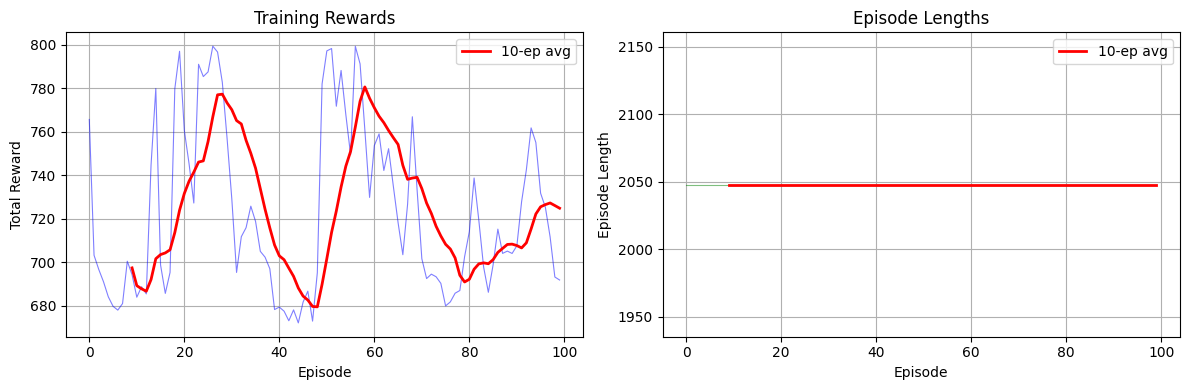

In [29]:
# =============================================================================
# Plot Training Progress
# =============================================================================

fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Episode rewards
ax1 = axes[0]
ax1.plot(episode_rewards, 'b-', alpha=0.5, linewidth=0.8)
window = 10
if len(episode_rewards) >= window:
    smoothed = np.convolve(episode_rewards, np.ones(window)/window, mode='valid')
    ax1.plot(range(window-1, len(episode_rewards)), smoothed, 'r-', linewidth=2, label=f'{window}-ep avg')
ax1.set_xlabel('Episode')
ax1.set_ylabel('Total Reward')
ax1.set_title('Training Rewards')
ax1.legend()
ax1.grid(True)

# Episode lengths
ax2 = axes[1]
ax2.plot(episode_lengths, 'g-', alpha=0.5, linewidth=0.8)
if len(episode_lengths) >= window:
    smoothed_len = np.convolve(episode_lengths, np.ones(window)/window, mode='valid')
    ax2.plot(range(window-1, len(episode_lengths)), smoothed_len, 'r-', linewidth=2, label=f'{window}-ep avg')
ax2.set_xlabel('Episode')
ax2.set_ylabel('Episode Length')
ax2.set_title('Episode Lengths')
ax2.legend()
ax2.grid(True)

plt.tight_layout()
plt.show()

In [30]:
# =============================================================================
# Evaluation: Run Trained Agent and Collect Data
# =============================================================================

n_eval_steps = 4096  # Longer evaluation for better spectral resolution
env.max_steps = n_eval_steps

obs, _ = env.reset()
done = False

while not done:
    action = mpo.policy.get_action(
        torch.FloatTensor(obs).unsqueeze(0).to(device),
        deterministic=True
    )[0]
    
    obs, reward, terminated, truncated, info = env.step(action)
    done = terminated or truncated

# Extract histories from environment
pitch_true = np.array(env.pitch_true_history)
pitch_measured = np.array(env.pitch_measured_history)
torque = np.array(env.torque_history)
seismic = np.array(env.seismic_history)
sensor_noise = np.array(env.sensor_noise_history)

print("=" * 60)
print("Evaluation Complete")
print("=" * 60)
print(f"Total steps: {len(pitch_true)}")
print(f"Duration: {len(pitch_true)/fs:.2f} s")
print(f"True pitch RMS: {np.std(pitch_true):.3e} rad")
print(f"Measured pitch RMS: {np.std(pitch_measured):.3e} rad")
print(f"Seismic noise RMS: {np.std(seismic):.3e}")
print(f"Sensor noise RMS: {np.std(sensor_noise):.3e} rad")

Evaluation Complete
Total steps: 4096
Duration: 16.00 s
True pitch RMS: 4.591e-10 rad
Measured pitch RMS: 4.591e-10 rad
Seismic noise RMS: 3.638e-08
Sensor noise RMS: 4.732e-13 rad


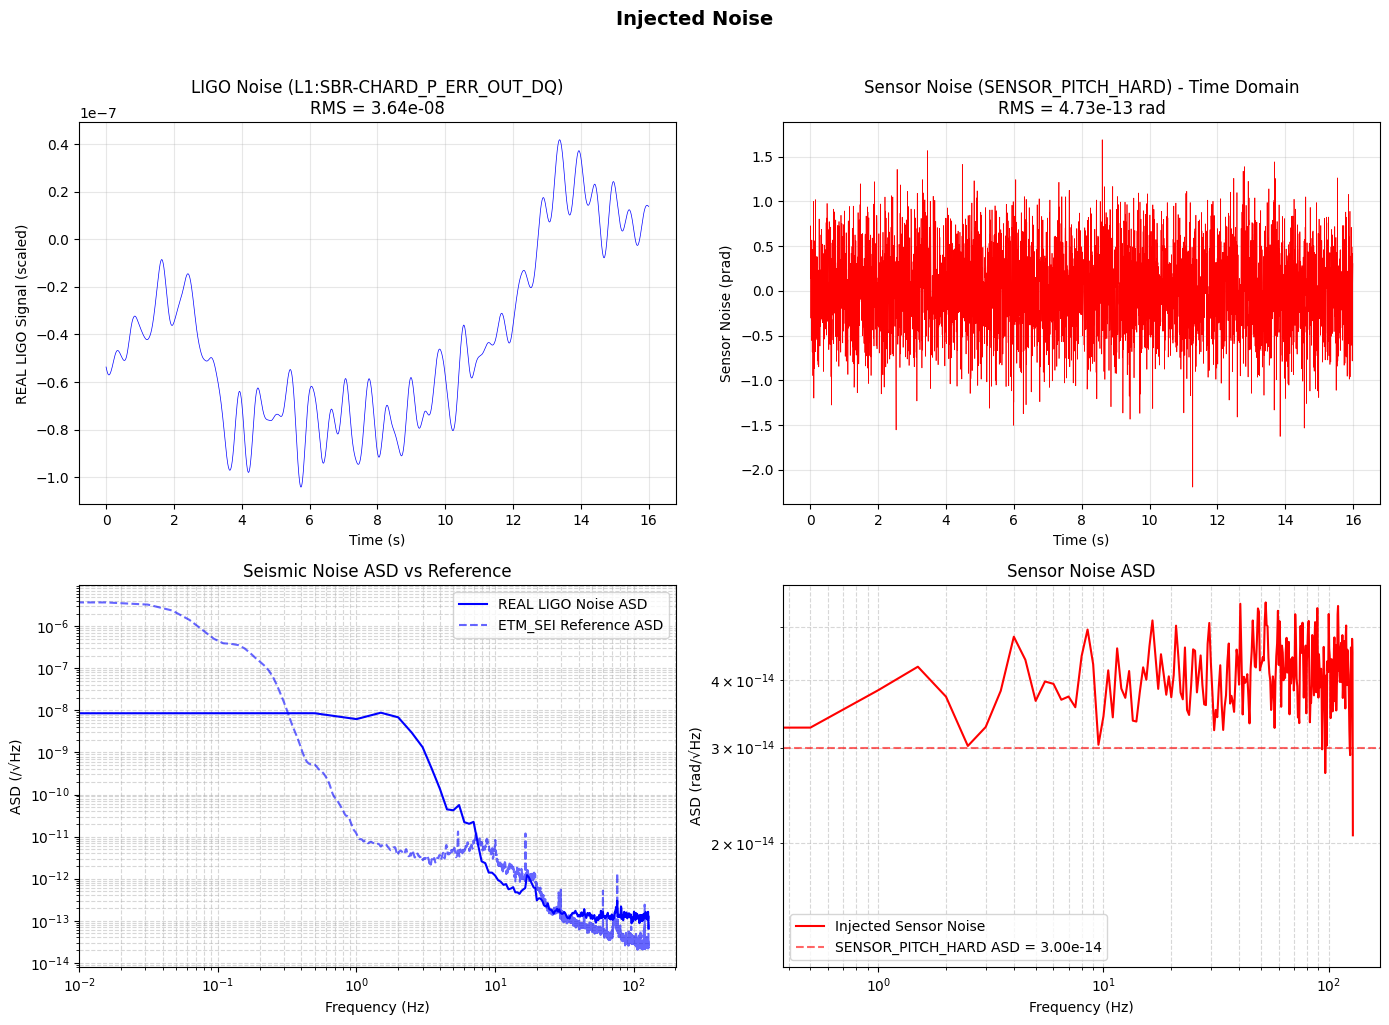


Noise Injection Summary

*** SEISMIC NOISE: REAL LIGO DATA ***
  Source: L1_1407160711.hdf5
  Channel: L1:SBR-CHARD_P_ERR_OUT_DQ
  Original sample rate: 2048 Hz (resampled to 256 Hz)
  Injection: Process disturbance (added to control input)
  Time-domain RMS: 3.638e-08

Sensor Noise (SENSOR_PITCH_HARD):
  Injection: Output measurement (additive)
  ASD level: 3.000e-14 rad/√Hz
  Time-domain RMS: 4.732e-13 rad


In [37]:
# =============================================================================
# Plot REAL Seismic Noise and Sensor Noise (Time Domain & ASD)
# =============================================================================

t = np.arange(len(seismic)) / fs
nperseg = min(512, len(seismic)//4)

# Compute ASDs
freq_seismic, psd_seismic = welch(seismic, fs, nperseg=nperseg)
seismic_asd = np.sqrt(psd_seismic)

freq_sensor, psd_sensor = welch(sensor_noise, fs, nperseg=nperseg)
sensor_asd = np.sqrt(psd_sensor)

fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# REAL seismic noise time domain
ax1 = axes[0, 0]
ax1.plot(t, seismic, 'b-', linewidth=0.5)
ax1.set_xlabel('Time (s)')
ax1.set_ylabel('REAL LIGO Signal (scaled)')
ax1.set_title(f'LIGO Noise (L1:SBR-CHARD_P_ERR_OUT_DQ)\nRMS = {np.std(seismic):.2e}')
ax1.grid(True, alpha=0.3)
ax1.ticklabel_format(style='scientific', axis='y', scilimits=(0,0))

# Sensor noise time domain
ax2 = axes[0, 1]
ax2.plot(t, sensor_noise * 1e12, 'r-', linewidth=0.5)
ax2.set_xlabel('Time (s)')
ax2.set_ylabel('Sensor Noise (prad)')
ax2.set_title(f'Sensor Noise (SENSOR_PITCH_HARD) - Time Domain\nRMS = {np.std(sensor_noise):.2e} rad')
ax2.grid(True, alpha=0.3)

# REAL seismic noise ASD
ax3 = axes[1, 0]
ax3.loglog(freq_seismic, seismic_asd, 'b-', linewidth=1.5, label='REAL LIGO Noise ASD')
ax3.loglog(freq_sei, sei_asd, 'b--', linewidth=1.5, alpha=0.6, label='ETM_SEI Reference ASD')
ax3.set_xlabel('Frequency (Hz)')
ax3.set_ylabel('ASD (/√Hz)')
ax3.set_title('Seismic Noise ASD vs Reference')
ax3.legend()
ax3.grid(True, which='both', linestyle='--', alpha=0.5)

# Sensor noise ASD
ax4 = axes[1, 1]
ax4.loglog(freq_sensor, sensor_asd, 'r-', linewidth=1.5, label='Injected Sensor Noise')
ax4.axhline(sensor_noise_level, color='r', linestyle='--', linewidth=1.5, alpha=0.6, 
            label=f'SENSOR_PITCH_HARD ASD = {sensor_noise_level:.2e}')
ax4.set_xlabel('Frequency (Hz)')
ax4.set_ylabel('ASD (rad/√Hz)')
ax4.set_title('Sensor Noise ASD')
ax4.legend()
ax4.grid(True, which='both', linestyle='--', alpha=0.5)

plt.suptitle('Injected Noise', fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

print("\n" + "=" * 60)
print("Noise Injection Summary")
print("=" * 60)
print(f"\n*** SEISMIC NOISE: REAL LIGO DATA ***")
print(f"  Source: L1_1407160711.hdf5")
print(f"  Channel: L1:SBR-CHARD_P_ERR_OUT_DQ")
print(f"  Original sample rate: 2048 Hz (resampled to 256 Hz)")
print(f"  Injection: Process disturbance (added to control input)")
print(f"  Time-domain RMS: {np.std(seismic):.3e}")
print(f"\nSensor Noise (SENSOR_PITCH_HARD):")
print(f"  Injection: Output measurement (additive)")
print(f"  ASD level: {sensor_noise_level:.3e} rad/√Hz")
print(f"  Time-domain RMS: {np.std(sensor_noise):.3e} rad")

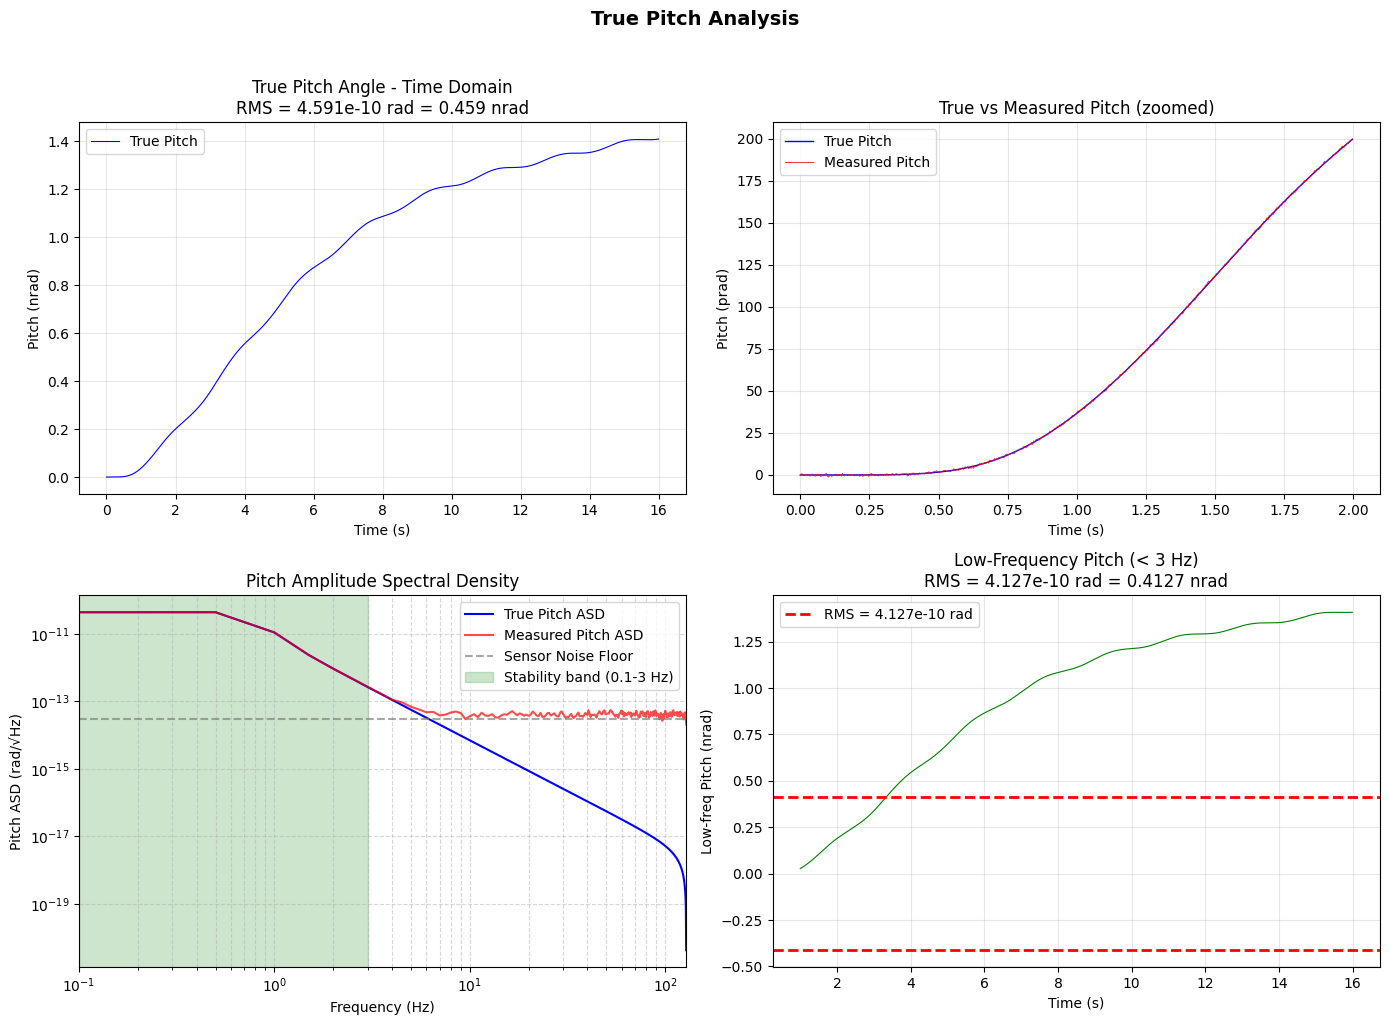


Pitch RMS Summary

True Pitch:
  Total RMS: 4.591e-10 rad = 0.459 nrad
  Low-freq RMS (< 3 Hz): 4.127e-10 rad = 0.4127 nrad

Measured Pitch:
  Total RMS: 4.591e-10 rad = 0.459 nrad


In [32]:
# =============================================================================
# Plot True Pitch: Time Domain and ASD
# =============================================================================

# Compute ASD of true pitch
freq_pitch, psd_pitch = welch(pitch_true, fs, nperseg=nperseg)
pitch_asd = np.sqrt(psd_pitch)

# Compute ASD of measured pitch
freq_measured, psd_measured = welch(pitch_measured, fs, nperseg=nperseg)
measured_asd = np.sqrt(psd_measured)

# Calculate RMS values
pitch_rms = np.std(pitch_true)
measured_rms = np.std(pitch_measured)

# Low-frequency RMS (0.1-3 Hz for stability)
b_lf, a_lf = butter(2, 3.0 / (fs/2), btype='low')
pitch_lowfreq = lfilter(b_lf, a_lf, pitch_true)
# Discard transient
transient_samples = int(fs * 1.0)  # 1 second transient
pitch_lowfreq_rms = np.std(pitch_lowfreq[transient_samples:])

fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# True pitch time domain
ax1 = axes[0, 0]
ax1.plot(t, pitch_true * 1e9, 'b-', linewidth=0.8, label='True Pitch')
ax1.set_xlabel('Time (s)')
ax1.set_ylabel('Pitch (nrad)')
ax1.set_title(f'True Pitch Angle - Time Domain\nRMS = {pitch_rms:.3e} rad = {pitch_rms*1e9:.3f} nrad')
ax1.grid(True, alpha=0.3)
ax1.legend()

# True vs Measured pitch (zoomed)
ax2 = axes[0, 1]
t_zoom = slice(0, min(512, len(t)))
ax2.plot(t[t_zoom], pitch_true[t_zoom] * 1e12, 'b-', linewidth=1, label='True Pitch')
ax2.plot(t[t_zoom], pitch_measured[t_zoom] * 1e12, 'r-', linewidth=0.7, alpha=0.8, label='Measured Pitch')
ax2.set_xlabel('Time (s)')
ax2.set_ylabel('Pitch (prad)')
ax2.set_title('True vs Measured Pitch (zoomed)')
ax2.legend()
ax2.grid(True, alpha=0.3)

# Pitch ASD
ax3 = axes[1, 0]
ax3.loglog(freq_pitch, pitch_asd, 'b-', linewidth=1.5, label='True Pitch ASD')
ax3.loglog(freq_measured, measured_asd, 'r-', linewidth=1.5, alpha=0.7, label='Measured Pitch ASD')
ax3.axhline(sensor_noise_level, color='gray', linestyle='--', alpha=0.7, label='Sensor Noise Floor')
ax3.axvspan(0.1, 3, alpha=0.2, color='green', label='Stability band (0.1-3 Hz)')
ax3.set_xlabel('Frequency (Hz)')
ax3.set_ylabel('Pitch ASD (rad/√Hz)')
ax3.set_title('Pitch Amplitude Spectral Density')
ax3.legend()
ax3.grid(True, which='both', linestyle='--', alpha=0.5)
ax3.set_xlim([0.1, fs/2])

# Low-frequency pitch (band-limited)
ax4 = axes[1, 1]
ax4.plot(t[transient_samples:], pitch_lowfreq[transient_samples:] * 1e9, 'g-', linewidth=0.8)
ax4.axhline(pitch_lowfreq_rms * 1e9, color='r', linestyle='--', linewidth=2, 
            label=f'RMS = {pitch_lowfreq_rms:.3e} rad')
ax4.axhline(-pitch_lowfreq_rms * 1e9, color='r', linestyle='--', linewidth=2)
ax4.set_xlabel('Time (s)')
ax4.set_ylabel('Low-freq Pitch (nrad)')
ax4.set_title(f'Low-Frequency Pitch (< 3 Hz)\nRMS = {pitch_lowfreq_rms:.3e} rad = {pitch_lowfreq_rms*1e9:.4f} nrad')
ax4.legend()
ax4.grid(True, alpha=0.3)

plt.suptitle('True Pitch Analysis', fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

print("\n" + "=" * 60)
print("Pitch RMS Summary")
print("=" * 60)
print(f"\nTrue Pitch:")
print(f"  Total RMS: {pitch_rms:.3e} rad = {pitch_rms*1e9:.3f} nrad")
print(f"  Low-freq RMS (< 3 Hz): {pitch_lowfreq_rms:.3e} rad = {pitch_lowfreq_rms*1e9:.4f} nrad")
print(f"\nMeasured Pitch:")
print(f"  Total RMS: {measured_rms:.3e} rad = {measured_rms*1e9:.3f} nrad")

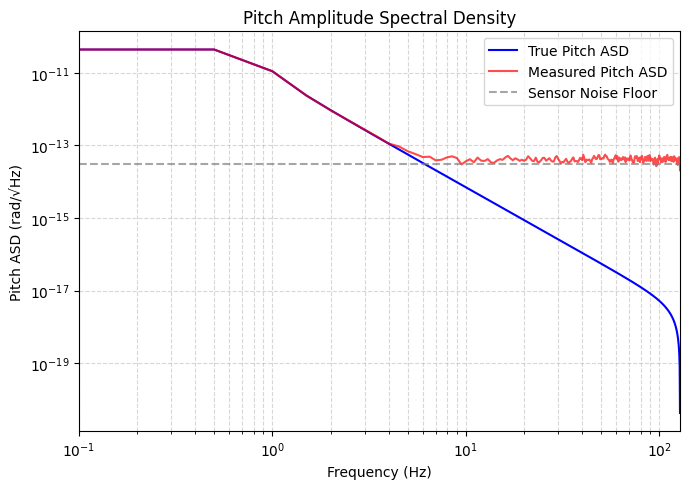

In [40]:
plt.figure(figsize=(7, 5))
plt.loglog(freq_pitch, pitch_asd, 'b-', linewidth=1.5, label='True Pitch ASD')
plt.loglog(freq_measured, measured_asd, 'r-', linewidth=1.5, alpha=0.7, label='Measured Pitch ASD')
plt.axhline(sensor_noise_level, color='gray', linestyle='--', alpha=0.7, label='Sensor Noise Floor')
# plt.axvspan(0.1, 3, alpha=0.2, color='green', label='Stability band (0.1–3 Hz)')

plt.xlabel('Frequency (Hz)')
plt.ylabel('Pitch ASD (rad/√Hz)')
plt.title('Pitch Amplitude Spectral Density')
plt.xlim([0.1, fs / 2])
plt.grid(True, which='both', linestyle='--', alpha=0.5)
plt.legend()

plt.tight_layout()
plt.show()

In [33]:
# =============================================================================
# Strain Sensitivity Calculation
# =============================================================================

# LIGO parameters (same as original notebook)
L_arm = 4000  # LIGO arm length in meters
pitch_to_length_coupling = 10e-7  # m/rad (typical coupling for LIGO)

# Conversion factor: strain = (pitch_angle × coupling_factor) / L_arm
pitch_to_strain_factor = pitch_to_length_coupling / L_arm

# Convert pitch ASD to strain ASD
strain_asd = pitch_asd * pitch_to_strain_factor
strain_measured_asd = measured_asd * pitch_to_strain_factor

# Calculate strain RMS
strain_rms = pitch_rms * pitch_to_strain_factor
strain_measured_rms = measured_rms * pitch_to_strain_factor
strain_lowfreq_rms = pitch_lowfreq_rms * pitch_to_strain_factor

# Load A+ sensitivity curve for comparison
aplus_path = '/Users/arushpimpalkar/work/timepass/RL_Arush/zenodo_data/noise_inputs/aicReferenceData_Aplus.txt'
try:
    aplus_data = np.loadtxt(aplus_path)
    aplus_freq = aplus_data[:, 0]
    aplus_strain = aplus_data[:, 4]  # Total noise curve
    has_aplus = True
except:
    has_aplus = False
    print("Note: A+ reference data not found")

print("=" * 60)
print("Strain Sensitivity Calculation")
print("=" * 60)
print(f"\nLIGO Parameters:")
print(f"  Arm length: {L_arm} m")
print(f"  Pitch-to-length coupling: {pitch_to_length_coupling:.1e} m/rad")
print(f"  Conversion factor: {pitch_to_strain_factor:.2e} strain/rad")

print(f"\nStrain RMS Values:")
print(f"  From true pitch:     {strain_rms:.3e}")
print(f"  From measured pitch: {strain_measured_rms:.3e}")
print(f"  Low-freq (< 3 Hz):   {strain_lowfreq_rms:.3e}")

Strain Sensitivity Calculation

LIGO Parameters:
  Arm length: 4000 m
  Pitch-to-length coupling: 1.0e-06 m/rad
  Conversion factor: 2.50e-10 strain/rad

Strain RMS Values:
  From true pitch:     1.148e-19
  From measured pitch: 1.148e-19
  Low-freq (< 3 Hz):   1.032e-19


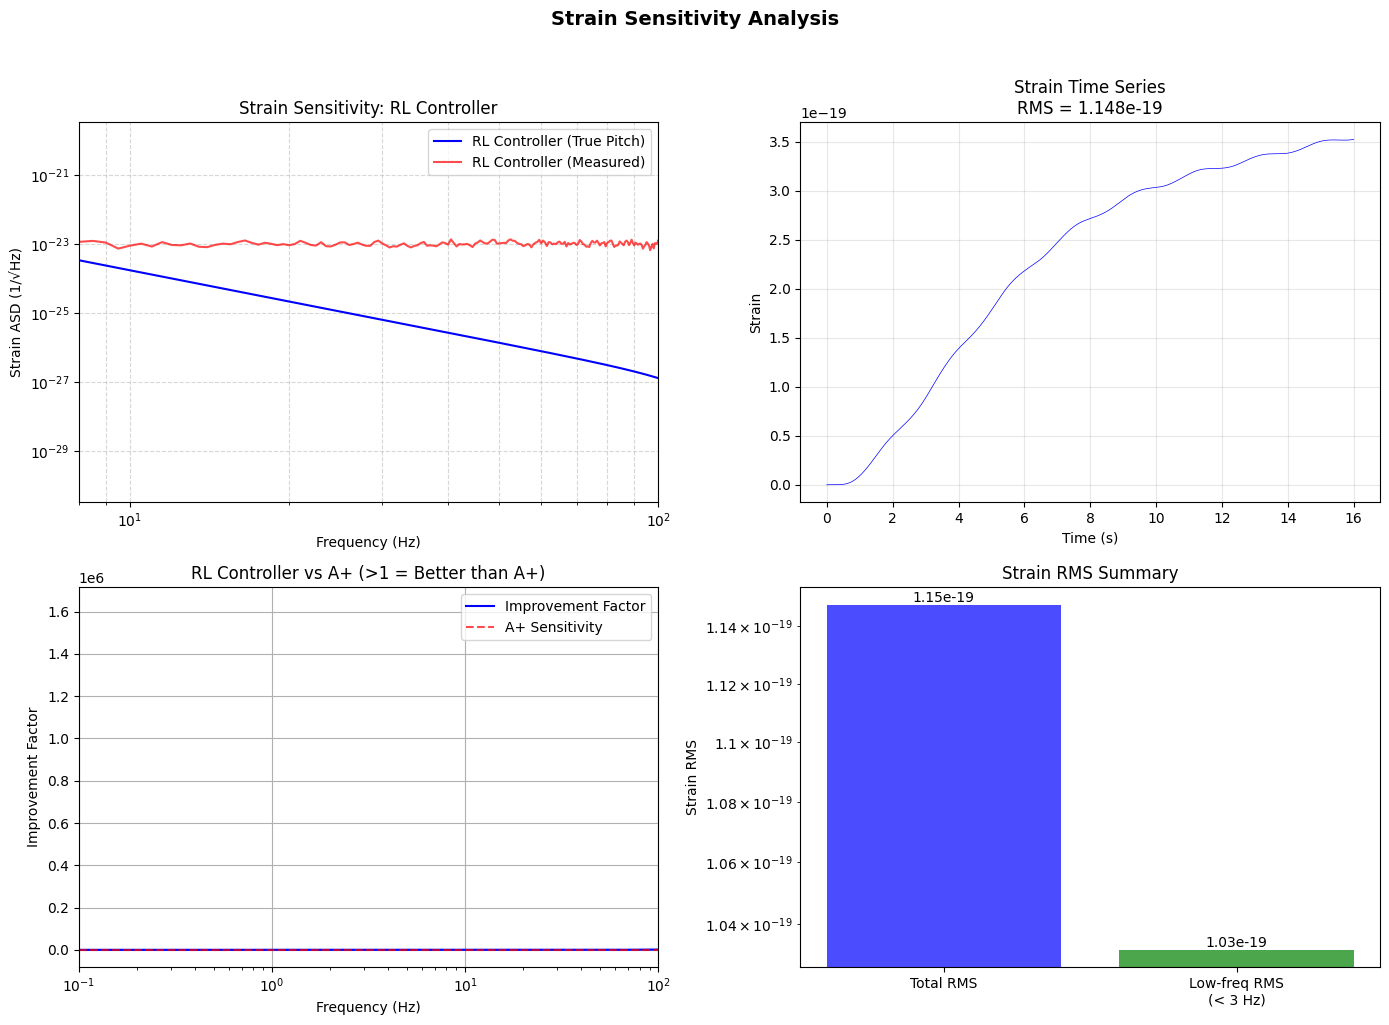


FINAL RESULTS SUMMARY

┌──────────────────────────────────────────────────────────┐
│                       PITCH ANGLE                        │
├──────────────────────────────────────────────────────────┤
│  Total RMS:            4.591e-10 rad =   0.4591 nrad │
│  Low-freq RMS:         4.127e-10 rad =   0.4127 nrad │
├──────────────────────────────────────────────────────────┤
│                    STRAIN SENSITIVITY                    │
├──────────────────────────────────────────────────────────┤
│  Total RMS:            1.148e-19                       │
│  Low-freq RMS:         1.032e-19                       │
├──────────────────────────────────────────────────────────┤
│                     NOISE INJECTION                      │
├──────────────────────────────────────────────────────────┤
│  Seismic RMS:          3.638e-08                       │
│  Sensor noise RMS:     4.732e-13 rad                  │
└──────────────────────────────────────────────────────────┘


In [34]:
# =============================================================================
# Plot Strain Sensitivity
# =============================================================================

fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Strain ASD comparison
ax1 = axes[0, 0]
ax1.loglog(freq_pitch, strain_asd, 'b-', linewidth=1.5, label='RL Controller (True Pitch)')
ax1.loglog(freq_measured, strain_measured_asd, 'r-', linewidth=1.5, alpha=0.7, label='RL Controller (Measured)')
# if has_aplus:
#     ax1.loglog(aplus_freq, aplus_strain, 'k--', linewidth=2, alpha=0.7, label='A+ Design Sensitivity')
ax1.set_xlabel('Frequency (Hz)')
ax1.set_ylabel('Strain ASD (1/√Hz)')
ax1.set_title('Strain Sensitivity: RL Controller')
ax1.legend()
ax1.grid(True, which='both', linestyle='--', alpha=0.5)
ax1.set_xlim([8, 100])

# Strain time series
strain_timeseries = pitch_true * pitch_to_strain_factor
ax2 = axes[0, 1]
ax2.plot(t, strain_timeseries, 'b-', linewidth=0.5)
ax2.set_xlabel('Time (s)')
ax2.set_ylabel('Strain')
ax2.set_title(f'Strain Time Series\nRMS = {strain_rms:.3e}')
ax2.grid(True, alpha=0.3)
ax2.ticklabel_format(style='scientific', axis='y', scilimits=(0,0))

# Improvement factor (if A+ data available)
ax3 = axes[1, 0]
if has_aplus:
    aplus_interp = np.interp(freq_pitch, aplus_freq, aplus_strain)
    improvement = aplus_interp / strain_asd
    ax3.semilogx(freq_pitch, improvement, 'b-', linewidth=1.5, label='Improvement Factor')
    ax3.axhline(1, color='red', linestyle='--', alpha=0.7, label='A+ Sensitivity')
    ax3.set_xlabel('Frequency (Hz)')
    ax3.set_ylabel('Improvement Factor')
    ax3.set_title('RL Controller vs A+ (>1 = Better than A+)')
    ax3.legend()
    ax3.grid(True)
    ax3.set_xlim([0.1, 100])
else:
    ax3.text(0.5, 0.5, 'A+ Reference Data Not Available', ha='center', va='center', transform=ax3.transAxes)
    ax3.set_title('Improvement Factor')

# Summary bar chart
ax4 = axes[1, 1]
labels = ['Total RMS', 'Low-freq RMS\n(< 3 Hz)']
values = [strain_rms, strain_lowfreq_rms]
colors = ['blue', 'green']
bars = ax4.bar(labels, values, color=colors, alpha=0.7)
ax4.set_ylabel('Strain RMS')
ax4.set_title('Strain RMS Summary')
ax4.set_yscale('log')
ax4.grid(True, alpha=0.3, axis='y')

# Add value labels on bars
for bar, val in zip(bars, values):
    ax4.text(bar.get_x() + bar.get_width()/2, bar.get_height(), 
             f'{val:.2e}', ha='center', va='bottom', fontsize=10)

plt.suptitle('Strain Sensitivity Analysis', fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

print("\n" + "=" * 60)
print("FINAL RESULTS SUMMARY")
print("=" * 60)
print(f"\n┌{'─'*58}┐")
print(f"│{'PITCH ANGLE':^58}│")
print(f"├{'─'*58}┤")
print(f"│  Total RMS:         {pitch_rms:>12.3e} rad = {pitch_rms*1e9:>8.4f} nrad │")
print(f"│  Low-freq RMS:      {pitch_lowfreq_rms:>12.3e} rad = {pitch_lowfreq_rms*1e9:>8.4f} nrad │")
print(f"├{'─'*58}┤")
print(f"│{'STRAIN SENSITIVITY':^58}│")
print(f"├{'─'*58}┤")
print(f"│  Total RMS:         {strain_rms:>12.3e}                       │")
print(f"│  Low-freq RMS:      {strain_lowfreq_rms:>12.3e}                       │")
print(f"├{'─'*58}┤")
print(f"│{'NOISE INJECTION':^58}│")
print(f"├{'─'*58}┤")
print(f"│  Seismic RMS:       {np.std(seismic):>12.3e}                       │")
print(f"│  Sensor noise RMS:  {np.std(sensor_noise):>12.3e} rad                  │")
print(f"└{'─'*58}┘")

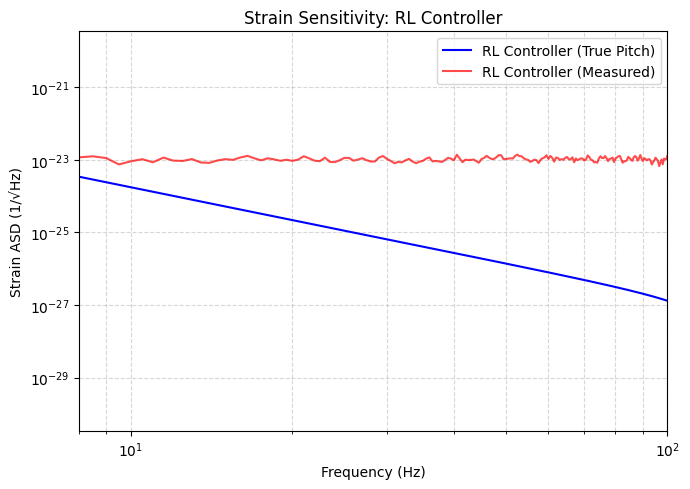

In [43]:
import matplotlib.pyplot as plt

plt.figure(figsize=(7, 5))
plt.loglog(freq_pitch, strain_asd, 'b-', linewidth=1.5, label='RL Controller (True Pitch)')
plt.loglog(freq_measured, strain_measured_asd, 'r-', linewidth=1.5, alpha=0.7, label='RL Controller (Measured)')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Strain ASD (1/√Hz)')
plt.title('Strain Sensitivity: RL Controller')
plt.xlim([8, 100])
plt.grid(True, which='both', linestyle='--', alpha=0.5)
plt.legend()

plt.tight_layout()
plt.show()
